In [2]:
from __future__ import annotations

from typing import Final
from urllib.error import HTTPError

import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from matplotlib import pyplot as plt
from pandas import DataFrame, Series
from rich.console import Console
from sklearn.metrics import f1_score
from spacy import Language
from spacy.tokens import Doc

In [3]:
console: Console = Console()

In [4]:
! python -m spacy download es_core_news_md
nltk.download("stopwords")

     ---------------------------------------- 0.0/42.3 MB ? eta -:--:--
     - -------------------------------------- 1.8/42.3 MB 9.1 MB/s eta 0:00:05
     -- ------------------------------------- 3.1/42.3 MB 7.7 MB/s eta 0:00:06
     ---- ----------------------------------- 4.5/42.3 MB 7.3 MB/s eta 0:00:06
     ----- ---------------------------------- 5.8/42.3 MB 7.0 MB/s eta 0:00:06
     ------ --------------------------------- 7.1/42.3 MB 6.9 MB/s eta 0:00:06
     ------- -------------------------------- 8.4/42.3 MB 6.8 MB/s eta 0:00:05
     --------- ------------------------------ 9.7/42.3 MB 6.8 MB/s eta 0:00:05
     ---------- ----------------------------- 11.0/42.3 MB 6.7 MB/s eta 0:00:05
     ----------- ---------------------------- 12.6/42.3 MB 6.7 MB/s eta 0:00:05
     ------------- -------------------------- 13.9/42.3 MB 6.7 MB/s eta 0:00:05
     -------------- ------------------------- 15.2/42.3 MB 6.6 MB/s eta 0:00:05
     --------------- ------------------------ 16.5/42.3

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dmbm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
GITHOME: Final[str] = ""

In [6]:
try:
    dataset: DataFrame = pd.read_csv(GITHOME + "data/train-dataset.csv", sep=";")
except HTTPError:
    dataset: DataFrame = pd.read_csv("data/train-dataset.csv", sep=";")

# 1. Entendiendo los Datos

# 2. Preparando los Datos

In [7]:
# Remove rows with missing values and drop the "ID" column
dataset = dataset.dropna().drop(columns=["ID"]).rename(columns={
    "Fecha": "date",
    "Label": "is-fake",
    "Titulo": "headline",
    "Descripcion": "body-content"
})

# Convert "date" column to datetime format
dataset["date"] = pd.to_datetime(dataset["date"], format="%d/%m/%Y")

# Convert "is-fake" column to boolean type
dataset["is-fake"] = dataset["is-fake"].astype(bool)

# Display a sample of few rows to verify changes
dataset.sample(10)


,is-fake,headline,body-content,date
33514,True,"El bloque del 'sí' a Sánchez sigue sumando, pe...",Pedro Sánchez se la jugará en la segunda vuelt...,2020-01-02
55208,False,Gallardo atesora 1.390.550 euros más que Crist...,La riqueza patrimonial de los ministros de Gal...,2018-09-30
16577,True,El Senado solo realizó un Pleno en esta legisl...,Tampoco han tenido ninguna actividad las comis...,2019-09-22
55327,True,DIRECTO | Barcelona vive su noche más violenta...,Te contamos minuto a minuto toda la informació...,2019-10-18
5593,False,"Félix López Rey y Mireia Vehí, los estrategas ...",El secretario general de los populares y el je...,2021-11-06
47223,False,Carmona renuncia ir en las listas del EQUO tra...,Es el tercer dirigente no estará en las candid...,2019-03-20
16915,False,"En el Día mundial de los animales, PP, el únic...",El partido morado ha puesto sobre la mesa hace...,2018-10-04
20223,False,"La Agrupación Madrid Ciudad, el nuevo órgano d...","La actual Delegada del Gobierno en Madrid, Jul...",2021-11-22
44689,True,"Alberto Ruiz-Gallardón, sobre el cambio de sed...",El que también fuera alcalde de la capital ent...,2021-02-21
27278,False,Mas y los exconsellers recurrirán la condena a...,"El expresident, Francesc Homs, Joana Ortega e ...",2018-11-12


In [8]:
stopwords: set[str] = set(nltk.corpus.stopwords.words("spanish"))
language: Language = spacy.load("es_core_news_md")

def profile(target: str | Series[str], *, prefix: str = None) -> dict[str, float] | Series:
    """
    Extracts linguistic features from a Spanish text (headline or body content).

    Parameters:
        target (str | Series[str]): The input text or a Series of text.
        prefix (str, optional): Prefix for feature names (required for Series).

    Returns:
        dict | Series: A dictionary of text features if `target` is a string,
                      or a Series of dictionaries if `target` is a Series.
    """
    # Type validation
    if not isinstance(target, str | Series):
        raise TypeError(f"`profile` expected `str` or `Series[str]`, but got {type(target).__name__}")

    if isinstance(target, Series):
        if target.name is None:
            raise ValueError("`profile` expected a named Series")
        return target.apply(profile, prefix=target.name)

    if not isinstance(prefix, str) or not prefix:
        raise ValueError("`prefix` must be a non-empty string")

    # Process text with spaCy
    doc: Doc = language(target)

    # Extract words (lemmatized), ignoring stopwords
    words: list[str] = [token.lemma_ for token in doc if token.is_alpha]
    count: int = len(words)
    count_safe = max(count, 1)  # Avoid division by zero

    # Compute lexical richness (unique words / total words)
    unique_words = set(words)
    lexical_richness = len(unique_words) / count_safe

    # Compute punctuation ratio
    punctuation_ratio = sum(1 for token in doc if token.is_punct) / len(target)

    # Precompute character sum for efficiency
    char_sum = sum(len(word) for word in words)

    # Compute text-based metrics efficiently
    return {
        f"{prefix}-length": len(target),  # Character count
        f"{prefix}-word-count": count,  # Total words
        f"{prefix}-avg-word-length": char_sum / count_safe,  # Avg. word length
        f"{prefix}-stopword-ratio": sum(1 for word in words if word in stopwords) / count_safe,  # Stopword %
        f"{prefix}-lexical-richness": lexical_richness,  # Unique words / total words
        f"{prefix}-punctuation-ratio": punctuation_ratio,  # Punctuation usage
        f"{prefix}-ner-count": len(doc.ents),  # Named Entities Count (NER)
        f"{prefix}-noun-ratio": sum(1 for token in doc if token.pos_ == "NOUN") / count_safe,
        f"{prefix}-verb-ratio": sum(1 for token in doc if token.pos_ == "VERB") / count_safe,
        f"{prefix}-adj-ratio": sum(1 for token in doc if token.pos_ == "ADJ") / count_safe,
        f"{prefix}-adv-ratio": sum(1 for token in doc if token.pos_ == "ADV") / count_safe,
    }

def transform(dataset: DataFrame, columns: list[str]) -> DataFrame:
    profiles: dict[str, Series[dict[str, ...]]] = {column: profile(dataset[column]) for column in columns}
    for column in columns:
        dataset = pd.concat([dataset, DataFrame(profiles[column].tolist(), index=dataset[column].index)], axis=1)
    return dataset.drop(columns=columns)

In [9]:
dataset = transform(dataset, ["headline", "body-content"])


KeyboardInterrupt



In [314]:
dataset

Index(['is-fake', 'date', 'headline-length', 'headline-word-count',
       'headline-avg-word-length', 'headline-stopword-ratio',
       'headline-lexical-richness', 'headline-punctuation-ratio',
       'headline-ner-count', 'headline-noun-ratio', 'headline-verb-ratio',
       'headline-adj-ratio', 'headline-adv-ratio', 'body-content-length',
       'body-content-word-count', 'body-content-avg-word-length',
       'body-content-stopword-ratio', 'body-content-lexical-richness',
       'body-content-punctuation-ratio', 'body-content-ner-count',
       'body-content-noun-ratio', 'body-content-verb-ratio',
       'body-content-adj-ratio', 'body-content-adv-ratio'],
      dtype='object')

C:\Users\dmbm\AppData\Local\Temp\ipykernel_78828\614657418.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataset["is-fake"], palette="coolwarm")


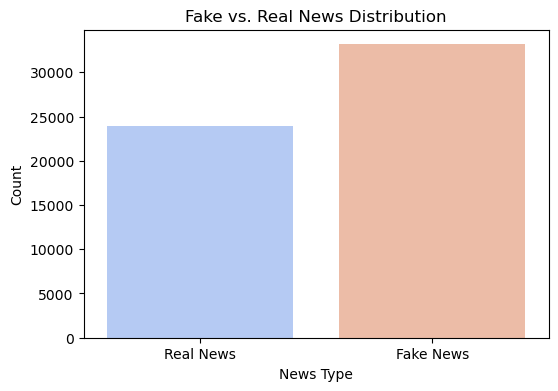

In [315]:
plt.figure(figsize=(6, 4))
sns.countplot(x=dataset["is-fake"], palette="coolwarm")
plt.xticks(ticks=[0, 1], labels=["Real News", "Fake News"])
plt.title("Fake vs. Real News Distribution")
plt.xlabel("News Type")
plt.ylabel("Count")
plt.show()


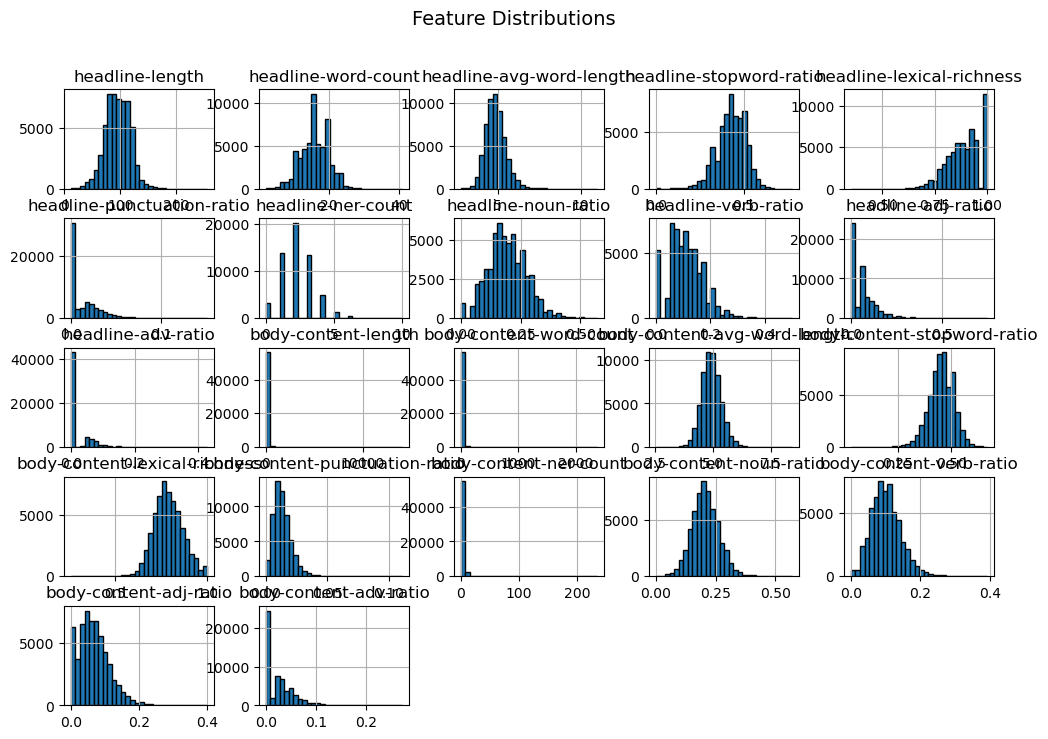

In [316]:
dataset.drop(columns=["is-fake", "date"]).hist(figsize=(12, 8), bins=30, edgecolor="black")
plt.suptitle("Feature Distributions", fontsize=14)
plt.show()


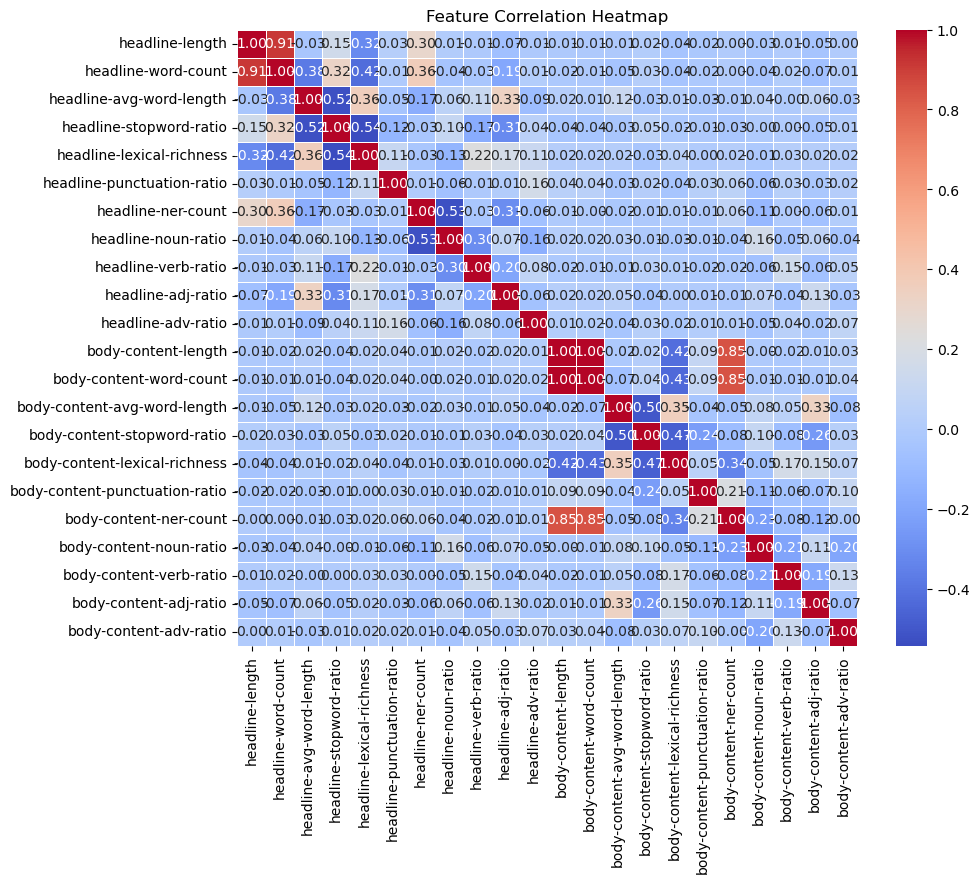

In [317]:
plt.figure(figsize=(10, 8))
sns.heatmap(dataset.drop(columns=["is-fake", "date"]).corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


C:\Users\dmbm\AppData\Local\Temp\ipykernel_78828\1694472338.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=dataset["is-fake"], y=dataset[column], palette="coolwarm")
C:\Users\dmbm\AppData\Local\Temp\ipykernel_78828\1694472338.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=dataset["is-fake"], y=dataset[column], palette="coolwarm")
C:\Users\dmbm\AppData\Local\Temp\ipykernel_78828\1694472338.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=dataset["is-fake"], y=dataset[column], palette="coolwarm")
C:\Users\dmbm\AppData\Local\

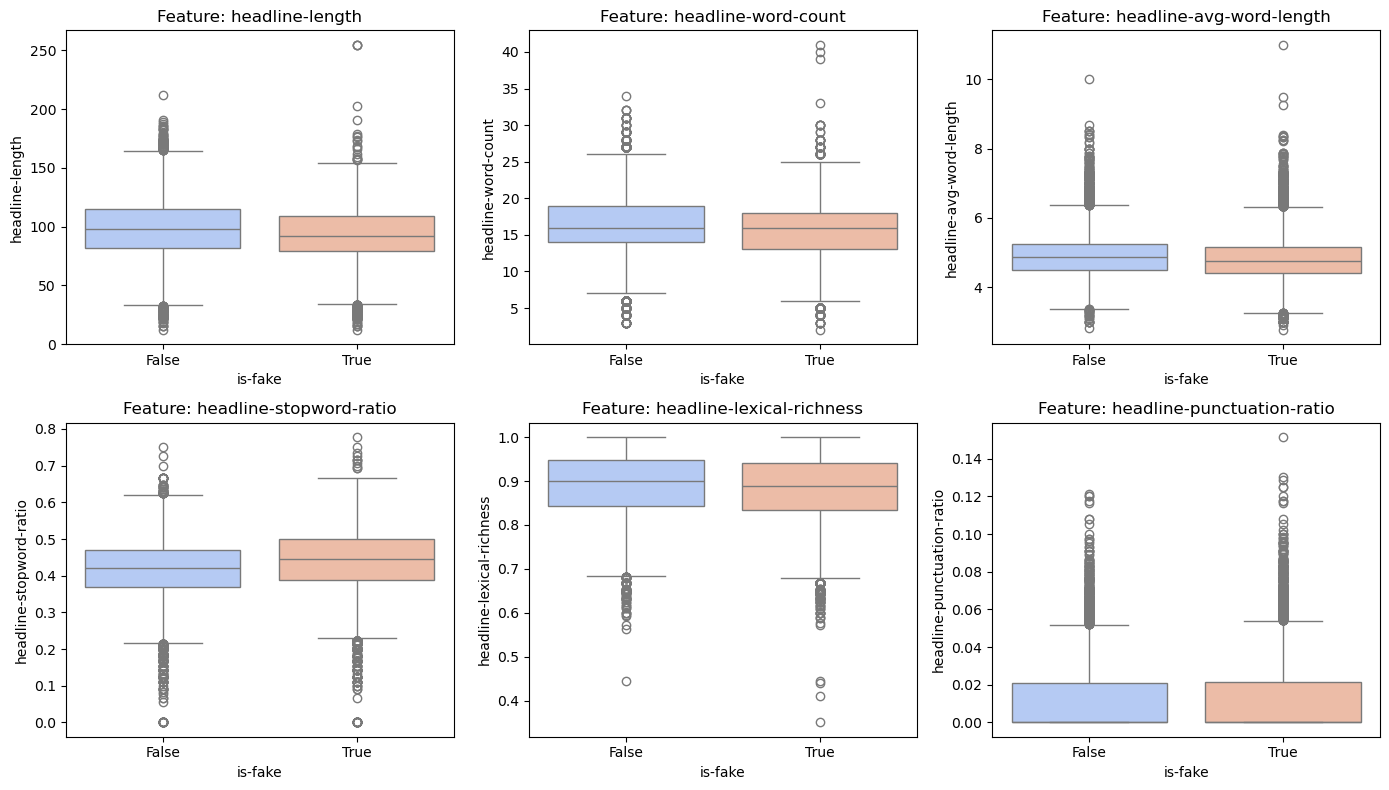

In [318]:
plt.figure(figsize=(14, 8))
for i, column in enumerate(dataset.drop(columns=["is-fake", "date"]).columns[:6], 1):  # First 6 features
    plt.subplot(2, 3, i)
    sns.boxplot(x=dataset["is-fake"], y=dataset[column], palette="coolwarm")
    plt.title(f"Feature: {column}")
plt.tight_layout()
plt.show()

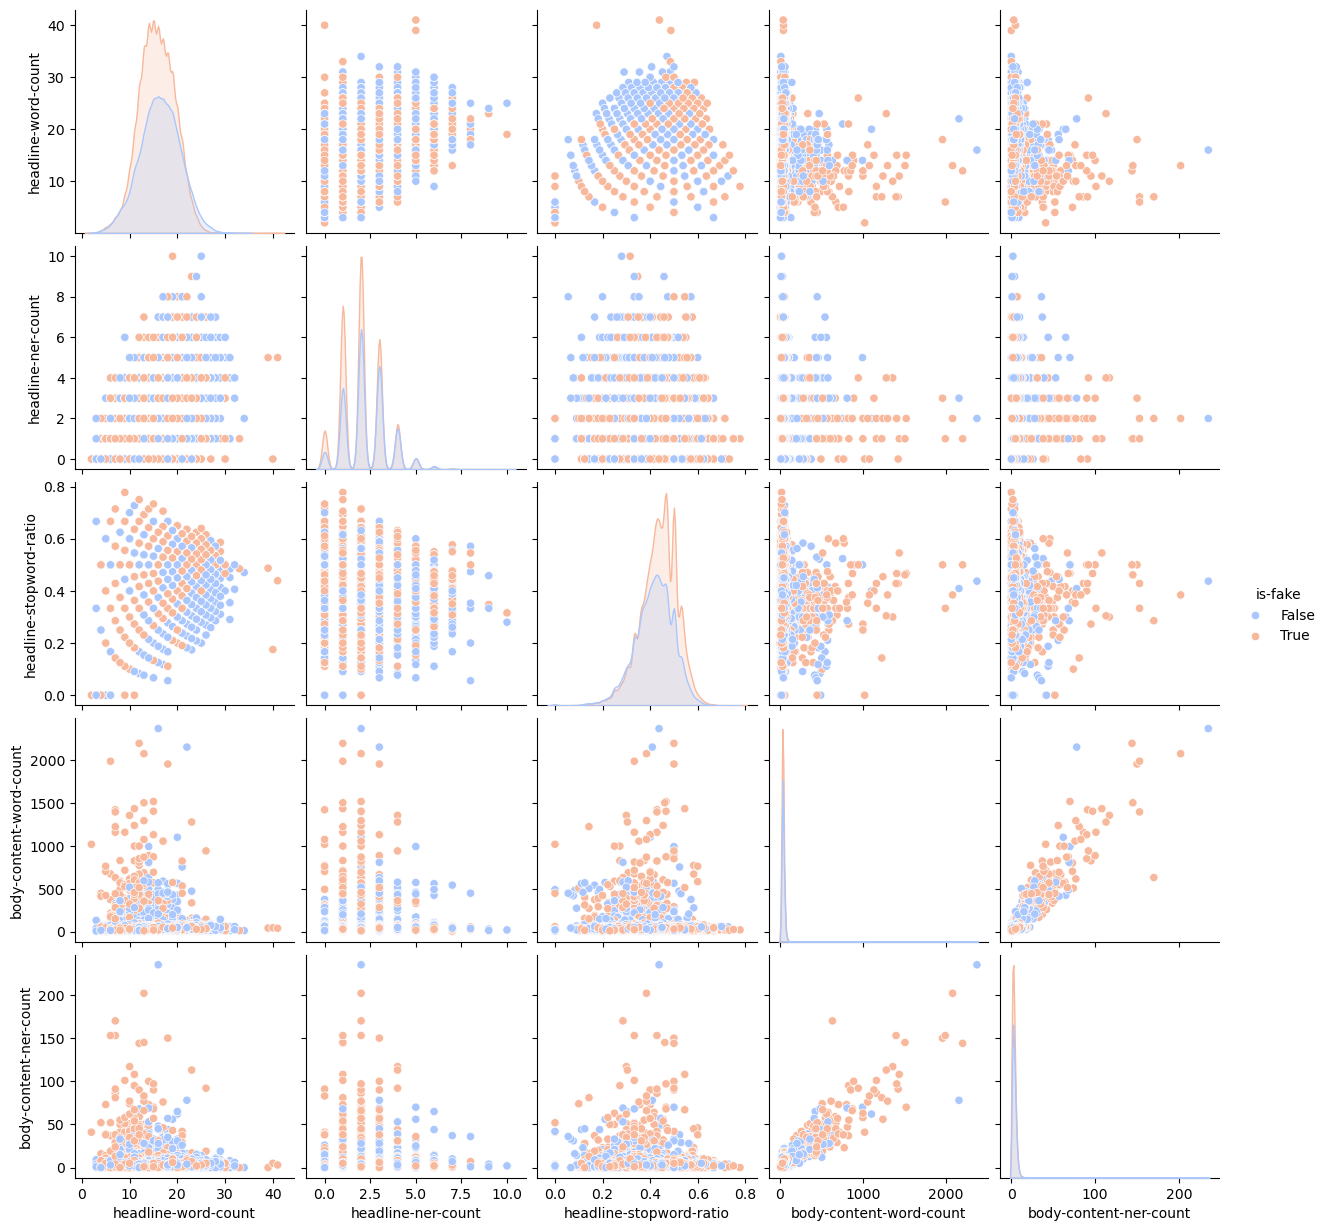

In [319]:
# Select key features (modify based on your analysis)
selected_features = [
    "headline-word-count", "headline-ner-count", "headline-stopword-ratio",
    "body-content-word-count", "body-content-ner-count", "is-fake"
]

# Create a more readable pairplot
sns.pairplot(dataset[selected_features], hue="is-fake", diag_kind="kde", palette="coolwarm")
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

x_train: DataFrame
y_train: Series[bool]
x_test: DataFrame
y_test: Series[bool]
x_train, x_test, y_train, y_test = train_test_split(dataset.drop(columns=["is-fake", "date"]), dataset["is-fake"])

In [1]:
from sklearn.neighbors import BallTree, KDTree, KNeighborsClassifier, KNeighborsRegressor, KNeighborsTransformer, \
    NearestCentroid, NearestNeighbors, RadiusNeighborsClassifier, RadiusNeighborsRegressor, RadiusNeighborsTransformer, \
    KernelDensity, LocalOutlierFactor, NeighborhoodComponentsAnalysis


class ModelSelector:
    def __init__(self) -> None:
        self._models: dict[str, ...] = {
            "KNeighborsClassifier": KNeighborsClassifier(),
            "KNeighborsRegressor": KNeighborsRegressor(),
            "KNeighborsTransformer": KNeighborsTransformer(),
            "NearestCentroid": NearestCentroid(),
            "NearestNeighbors": NearestNeighbors(),
            "RadiusNeighborsClassifier": RadiusNeighborsClassifier(),
            "RadiusNeighborsRegressor": RadiusNeighborsRegressor(),
            "RadiusNeighborsTransformer": RadiusNeighborsTransformer(),
            "KernelDensity": KernelDensity(),
            "LocalOutlierFactor": LocalOutlierFactor(),
            "NeighborhoodComponentsAnalysis": NeighborhoodComponentsAnalysis(),
        }

        self._metrics = {
            "KNeighborsClassifier": {},
            "KNeighborsRegressor": {},
            "KNeighborsTransformer": {},
            "NearestCentroid": {},
            "NearestNeighbors": {},
            "RadiusNeighborsClassifier": {},
            "RadiusNeighborsRegressor": {},
            "RadiusNeighborsTransformer": {},
            "KernelDensity": {},
            "LocalOutlierFactor": {},
            "NeighborhoodComponentsAnalysis": {},
        }

    def train(self, x: DataFrame, y: Series[bool]) -> None:
        for name, model in self._models.items():
            console.log(model)
            model.fit(x, y)

    def test(self, x: DataFrame, y: Series[bool]) -> None:
        for name, model in self._models.items():
            predictions: Series[bool] = model.predict(x)
            self._metrics[name]["F1-Score"] = f1_score(y, predictions, average="weighted")

selector: ModelSelector = ModelSelector()
selector.train(x_train, y_train)
selector.test(x_test, y_test)
selector._metrics

NameError: name 'DataFrame' is not defined